In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
df = pd.read_csv("nyc_taxi.csv")

df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.set_index('timestamp')

print(df.head())

                     value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656
2014-07-01 02:00:00   3820


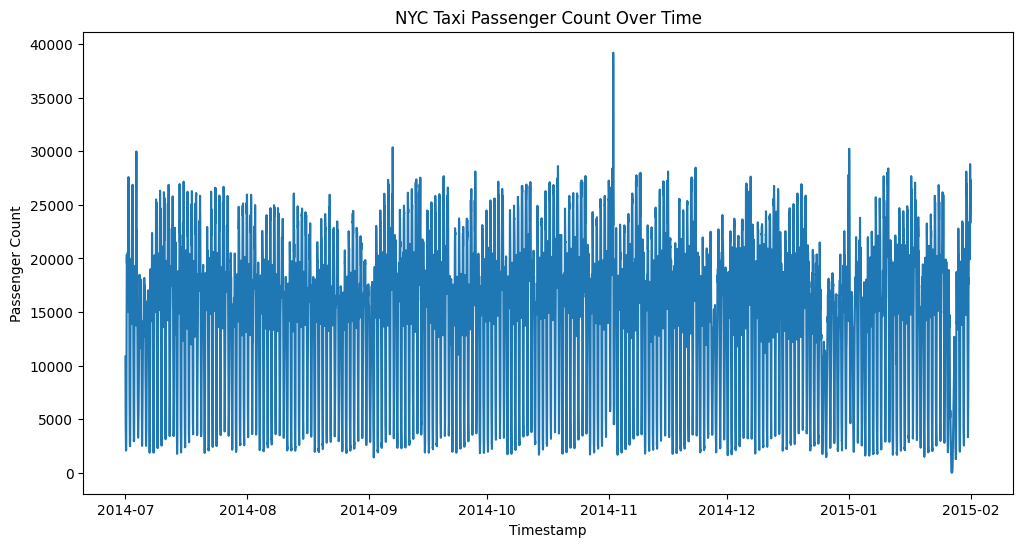

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(df['value'])
plt.title('NYC Taxi Passenger Count Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Passenger Count')
plt.show()

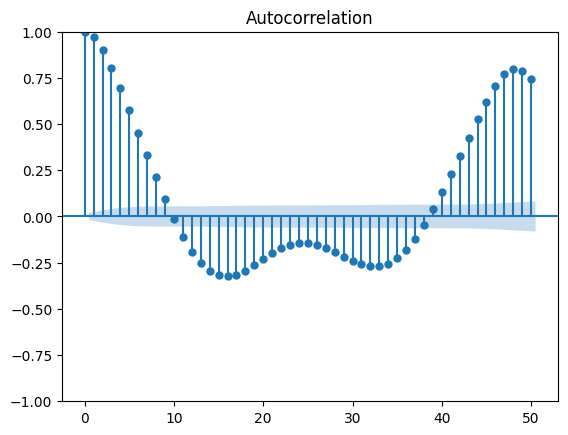

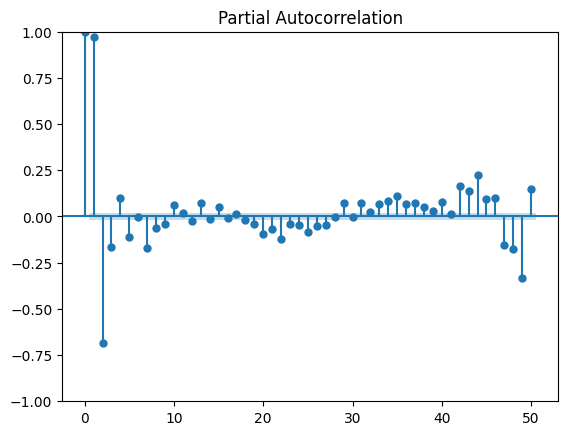

In [6]:


# ACF Plot
plot_acf(df['value'], lags=50)
plt.show()

# PACF Plot
plot_pacf(df['value'], lags=50)
plt.show()


In [7]:

scaler = MinMaxScaler()
df['value'] = scaler.fit_transform(df['value'].values.reshape(-1, 1))


def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


seq_length = 24


X, y = create_sequences(df['value'], seq_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17572\278861493.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = data[i + seq_length]


In [8]:
d_model = 32  # Embedding dimension
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feedforward network
dropout_rate = 0.1


inputs = layers.Input(shape=(seq_length, 1))

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)


  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])


  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

pos_encoding = positional_encoding(seq_length, d_model)
x = inputs + pos_encoding[:, :seq_length, :]

# Transformer Encoder
x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
x = layers.Dropout(dropout_rate)(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

# Output layer
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)


model = keras.Model(inputs=inputs, outputs=outputs)


model.compile(optimizer="adam", loss="mse")

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 24, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 24, 32)    │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 24, 32)    │      8,416 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 24, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 24, 32)    │         64 │ dropout_1[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 24, 32)    │      1,056 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 24, 32)    │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 24, 1)     │         33 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 24, 1)     │          2 │ conv1d_1[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,573 (37.39 KB)

 Trainable params: 9,573 (37.39 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ]
)

Epoch 1/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.1120 - val_loss: 0.0343
Epoch 2/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0302 - val_loss: 0.0322
Epoch 3/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0307 - val_loss: 0.0321
Epoch 4/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0306 - val_loss: 0.0321
Epoch 5/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0303 - val_loss: 0.0325
Epoch 6/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0309 - val_loss: 0.0320
Epoch 7/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0306 - val_loss: 0.0321
Epoch 8/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0313 - val_loss: 0.0319
Epoch 9/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0305 - val_loss: 0.0325
Epoch 10/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0302 - val_loss: 0.0323
Epoch 11/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0308 - val_loss: 0.0323
Epoch 12/20
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s

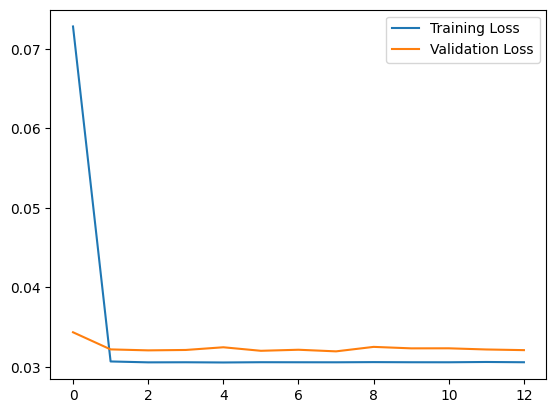

In [10]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [18]:

y_pred = model.predict(X_test)


y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))


mae = np.mean(np.abs(y_pred_rescaled - y_test_rescaled), axis=1)


threshold = np.percentile(mae, 50)


anomalies = mae > threshold

anomaly_indices = np.where(anomalies)[0]
anomaly_timestamps = df.index[seq_length:][train_size:][anomaly_indices]
print("Anomalies detected at timestamps:")
print(anomaly_timestamps)



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Anomalies detected at timestamps:
DatetimeIndex(['2014-12-20 04:30:00', '2014-12-20 05:00:00',
               '2014-12-20 05:30:00', '2014-12-20 06:00:00',
               '2014-12-20 06:30:00', '2014-12-20 07:00:00',
               '2014-12-20 07:30:00', '2014-12-20 08:00:00',
               '2014-12-20 08:30:00', '2014-12-20 11:30:00',
               ...
               '2015-01-31 19:00:00', '2015-01-31 19:30:00',
               '2015-01-31 20:00:00', '2015-01-31 20:30:00',
               '2015-01-31 21:00:00', '2015-01-31 21:30:00',
               '2015-01-31 22:00:00', '2015-01-31 22:30:00',
               '2015-01-31 23:00:00', '2015-01-31 23:30:00'],
              dtype='datetime64[ns]', name='timestamp', length=1030, freq=None)


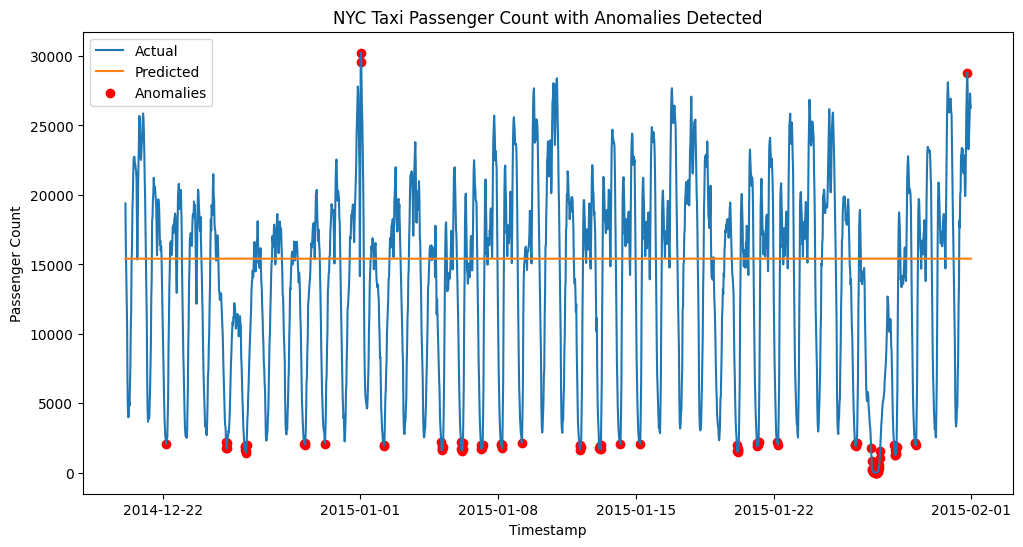

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[seq_length:][train_size:], y_test_rescaled, label='Actual')
plt.plot(df.index[seq_length:][train_size:], y_pred_rescaled, label='Predicted')
plt.scatter(anomaly_timestamps, y_test_rescaled[anomaly_indices], color='red', label='Anomalies')
plt.title('NYC Taxi Passenger Count with Anomalies Detected')
plt.xlabel('Timestamp')
plt.ylabel('Passenger Count')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

prediction_threshold = np.percentile(mae, 95)
y_pred_anomalies = (mae > prediction_threshold).astype(int)

anomaly_proportion = np.sum(y_pred_anomalies) / len(y_pred_anomalies) 
rng = np.random.default_rng(seed=42) 
y_eval_pseudo = rng.choice([0, 1], size=len(mae), p=[1-anomaly_proportion, anomaly_proportion])

precision = precision_score(y_eval_pseudo, y_pred_anomalies)
recall = recall_score(y_eval_pseudo, y_pred_anomalies)    
   

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Precision: 0.0777
Recall: 0.0734
